### Design for Co-Factor Swapping

The objective of this analysis is to investigate if productivity can be improved by swapping NADPH for NADH as a cofactor in the model, in order to optimize flux thorugh reactions requiring CYP71AV1. The co-factor swap analysis will determine if an increase in the available NADPH will lead to increased production of dihydroartemisinic acid, our target compound. The hypothesis proposed, that changing co-factor specificity may increase production of a target compound, is supported by work conducted by King and Feist (2014) who showed that co-factor swapping in central carbon metabolism has the potential to improve (theoretical) yields of some amino acids in _S. cerevisiae_. The main function used in this analysis is CofactorSwapAnalysis. In order to enhance the availability of a cofactor that is rate-limiting for the generation of a target metabolite and raise its theoretical yield, CofactorSwapOptimization uses an algorithm to determine which reactions in the model can undergo a swap in cofactor specificity.

In [1]:
# Initialising all required packages
from cobra.io import read_sbml_model, write_sbml_model #importing functions needed
from cobra import Reaction, Metabolite
from cameo.strain_design.heuristic.evolutionary_based import CofactorSwapOptimization
from cameo.strain_design.heuristic.evolutionary.objective_functions import product_yield
from cameo.strain_design.heuristic.evolutionary.optimization import CofactorSwapOptimization, NADH_NADPH

In [2]:
# Initialising mode
model = read_sbml_model("data/iYO844_modified.xml")
model

Name,iYO844
Memory address,0x07f945a1a6510
Number of metabolites,996
Number of reactions,1258
Number of groups,0
Objective expression,1.0*BIOMASS_BS_10 - 1.0*BIOMASS_BS_10_reverse_8788b
Compartments,"cytosol, extracellular space"


In [3]:
with model:
    base_max_growth = model.slim_optimize()
    print(base_max_growth)
    model.objective = model.reactions.ALDH1_CYP71AV1
    base_max_production = model.slim_optimize()
    print(base_max_production)

0.11796638932239784
0.36342857142856866


In [4]:
model.solver = "glpk" #specifying the solver for optimizing to be used as GLPK (GNU Linear Programming Kit)

biomass = model.reactions.BIOMASS_BS_10 #defining the biomass from the reaction describing biomass formation in our model

biomass.lower_bound = 0.1 # WHY ARE WE SETTING THE LOWER BOUND FOR THIS

demand = model.reactions.DM_dihydroartaci_c # Defining the demand for our target reaction of dihydroartemisinic acid
#DM_ defines the demand for us.

model.objective = demand # Setting the objective of the model to the variable demand
#men vi bruger ikke demand nogle steder herunder... 

In [5]:
#Her skal vi have vores nye boundary, som optimerer for produktionen af vores ønskede stof
# prod_yield = product_yield(demand, model.reactions.EX_glc__D_e)
prod_yield = product_yield(model.reactions.ALDH1_CYP71AV1, biomass)
prod_yield

In [6]:
# Swapping NADPH to NADH                                                                               
swap_opt = CofactorSwapOptimization(model=model, objective_function = prod_yield, plot=True, 
                                    cofactor_id_swaps=(['nad_c', 'nadh_c'], ['nadp_c', 'nadph_c']))

#we may not need to define the cofactor_id_swaps, as the ids in our model are the same as the default (but will it know what to change???)
# Yes it will

In [7]:
%%time
result = swap_opt.run(max_size=5) #can be changed, but I'M NOT QUITE SURE WHAT EXACTLY CHANGES (looks like time in min)
#we get no result right now, meaning nothing was found.... Can that be right?

Starting optimization at Tue, 21 Nov 2023 10:49:04


HBox()

Finished after 00:00:40
CPU times: user 1min 5s, sys: 583 ms, total: 1min 6s
Wall time: 1min 11s


The results of co-factor swapping analysis reveals one possible co-factor swap, that may lead to increased product formation; the GAPD reaction.

In [8]:
result

,index,targets,fitness


We investigate the GAPD function, to find it is catalyzed by glyceraldehyde-3-phosphate dehydrogenase.

In [9]:
model.reactions.GAPD

Reaction identifier,GAPD
Name,Glyceraldehyde-3-phosphate dehydrogenase
Memory address,0x0186099e3ec8
Stoichiometry,g3p_c + nad_c + pi_c --> 13dpg_c + h_c + nadh_c Glyceraldehyde 3-phosphate + Nicotinamide adenine dinucleotide + Phosphate --> 3-Phospho-D-glyceroyl phosphate + H+ + Nicotinamide adenine dinucleotide - reduced
GPR,BSU33940
Lower bound,0.0
Upper bound,999999.0


In [10]:
reaction1 = Reaction('GAPD_swap')
# The original reactions uses:
## g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
## Glyceraldehyde 3-phosphate + NAD(+) + free phosphate <=> 3-phospho-D-glyceroyl phosphate + H+ + NADH

# We can define the swapped reaction to change the NAD+ to NADP+ and the NADH to NADPH

reaction1.add_metabolites({
                            model.metabolites.get_by_id("g3p_c"): -1,
                            model.metabolites.get_by_id("nadp_c"): -1,
                            model.metabolites.get_by_id("pi_c"): -1,
                            model.metabolites.get_by_id("13dpg_c"): 1,
                            model.metabolites.get_by_id("h_c"): 1,
                            model.metabolites.get_by_id("nadph_c"): 1
                             })
                             
model.add_reactions([reaction1])

# Since the reaction has bounds of -1000 to 1000, we are also setting that here
model.reactions.GAPD_swap.bounds = -1000, 1000


In [11]:
model.reactions.GAPD_swap

Reaction identifier,GAPD_swap
Name,
Memory address,0x018609b761c8
Stoichiometry,g3p_c + nadp_c + pi_c <=> 13dpg_c + h_c + nadph_c Glyceraldehyde 3-phosphate + Nicotinamide adenine dinucleotide phosphate + Phosphate <=> 3-Phospho-D-glyceroyl phosphate + H+ + Nicotinamide adenine dinucleotide phosphate - reduced
GPR,
Lower bound,-1000
Upper bound,1000


In [12]:
model.reactions.GAPD.knock_out() #deleting/knocking-out the original GAPD reaction
model.reactions.GAPD #testing if bounds = 0, meaning nothing is produced

Reaction identifier,GAPD
Name,Glyceraldehyde-3-phosphate dehydrogenase
Memory address,0x0186099e3ec8
Stoichiometry,g3p_c + nad_c + pi_c --> 13dpg_c + h_c + nadh_c Glyceraldehyde 3-phosphate + Nicotinamide adenine dinucleotide + Phosphate --> 3-Phospho-D-glyceroyl phosphate + H+ + Nicotinamide adenine dinucleotide - reduced
GPR,BSU33940
Lower bound,0
Upper bound,0


We can now run a quick test to see if the co-factor swap has done any difference

In [13]:
with model:
    swap_max_growth = model.slim_optimize()
    print(swap_max_growth)
    model.objective = model.reactions.ALDH1_CYP71AV1
    swap_max_production = model.slim_optimize()
    print(swap_max_production)

0.055350504857146494
0.05535050485715061


In [14]:
print("Max growth has changed by", round((swap_max_growth-(base_max_growth))/(base_max_growth) * 100, 2), "percent")
print("Max production has changed by", round((swap_max_production-(base_max_production))/(base_max_production) * 100, 2), "percent")

Max growth has changed by -53.08 percent
Max production has changed by -84.77 percent


Since production of dihydroartemisinic acid also needs NADPH, a relatively lower growth and production rate in response to occupying this co-factor by other reactions is not surprising.

In [15]:
#A phenotypic phase plan can be simulated:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope, add_envelope
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
# In this plot, we are looking at the dynamics between the dihydroartesiminic acid producing reaction (ALDH1_CYP71AV1) and the biomass formation reaction (BIOMASS_BS_10)
ppp_GAPD_swap = production_envelope(model,
                    reactions=[model.reactions.ALDH1_CYP71AV1],
                    objective=model.reactions.BIOMASS_BS_10)

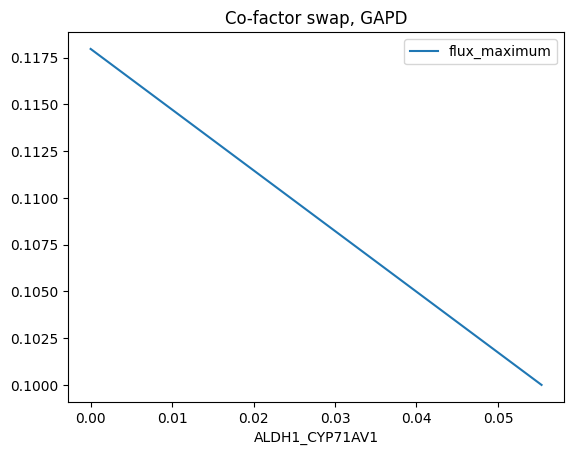

In [19]:
pppp = ppp_GAPD_swap.plot(x='ALDH1_CYP71AV1', y='flux_maximum')
fig = pppp.get_figure()
plt.title(label="Co-factor swap, GAPD")
fig.savefig("figures/co-factor_GAPD_swap.png")

From this plot, it is possible to see that very little has changed in the PPP, but that the maximal production of both biomass and dihydroartisiminic acid was decreased severely. #RIGHT?? MAYBE CHANGE THIS TEXT, IT IS VERY CLOSE TO THE ORIGINAL TEXT
We will save this version of the model as "iYO844_modified_GAPD_swap.xml" for co-factor swap. However, it will not be used for final production.

In [17]:
write_sbml_model(model, "data/iYO844_modified_GAPD_swap.xml")